In [1]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.3-py2.py3-none-any.whl size=240945068 sha256=f169177516808689e72fe7956049864ca8ac2b28611824df1900583e348d772b
  Stored in directory: /root/.cache/pip/wheels/f9/7d/1d/e1258f0558603969a8393cb5b22a18e313337f01627a118302
Successfully built h2o


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [4]:
# Load the dataset (assuming it's a CSV file)
data = pd.read_csv('/content/tweet_emotions.csv')
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [5]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values

tweet_id     0
sentiment    0
content      0
dtype: int64

In [6]:
data.columns

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

In [7]:
# Distribution of the sentiment column
sentiment_distribution = data['sentiment'].value_counts()
sentiment_distribution

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [8]:
# Basic statistics on the textual data
data['word_count'] = data['content'].str.split().apply(len)
average_word_count = data['word_count'].mean()
average_word_count

13.216875

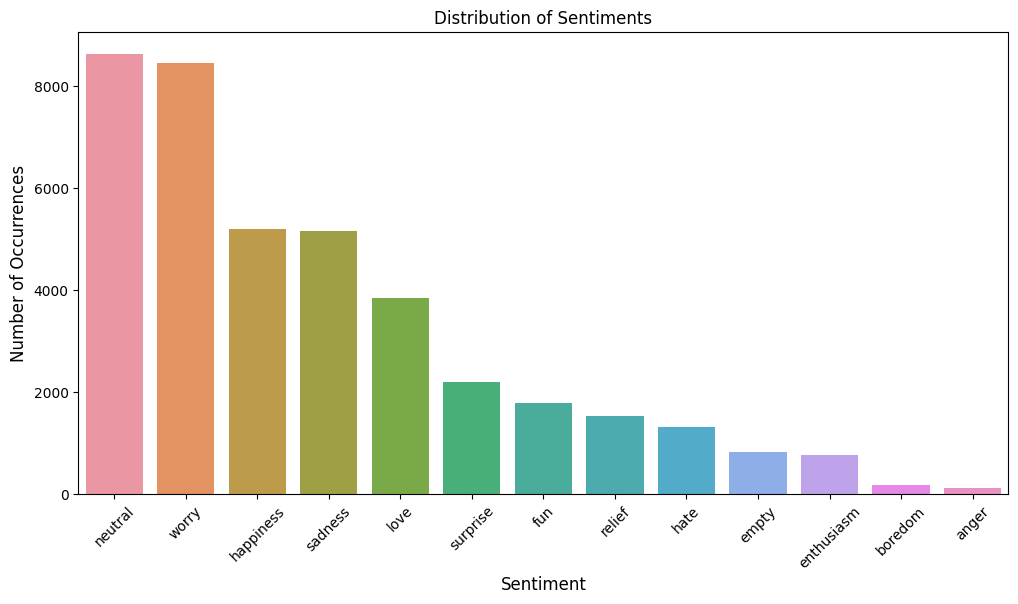

In [9]:
# Visualization of the sentiment distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values)
plt.title('Distribution of Sentiments')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show()


**Modify**

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download stopwords and wordnet from nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\\s]', '', text, re.I|re.A)
    text = text.lower()
    tokens = text.split()
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

data['content_processed'] = data['content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
# Convert text data to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=500)
tfidf_features = vectorizer.fit_transform(data['content_processed']).toarray()
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_features, columns=feature_names)

# Merge the TF-IDF features with the original data
data = pd.concat([data, tfidf_df], axis=1)

Index(['tweet_id', 'sentiment', 'content', 'word_count', 'sentiment_encoded'], dtype='object')

In [21]:
# Encoding the sentiment labels
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

# Splitting the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(data['content'], data['sentiment_encoded'], test_size=0.2, random_state=42)

In [22]:
# Initialize H2O
h2o.init(max_mem_size="2G", nthreads=-1)

# Convert pandas DataFrame to H2O Frame
h2o_data = h2o.H2OFrame(data)

# Split the dataset
train, test = h2o_data.split_frame(ratios=[0.8], seed=42)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 mins 04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,30 days
H2O_cluster_name:,H2O_from_python_unknownUser_7lv0dy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.995 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [24]:
# Specify the target and input features
target = "sentiment_encoded"
features = list(feature_names)# Using the TF-IDF feature names

# Run H2O AutoML
aml = H2OAutoML(max_models=20, seed=42, max_runtime_secs=1200)
aml.train(x=features, y=target, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head()

AutoML progress: |
02:42:04.144: _train param, Dropping bad and constant columns: [oneexperiencingproblemloggingdigitalpointforum, oneelsemuhahahaaaawellmaybejesse, oneinterlockonego, persononlinemsnfeellonely, feellikecrap, omgluvuguythankskeepinentertainedawakemissinmydgbigtyme, omgknowmanywordtimegoherewordmoneyballkey, omgneverknewwikipediaalsolistshadecolourcool, omgnicolekennedyfoundthnx, onlymegirlyescantseewontgrossenough, onlyhiscantwaitsee, omgimsadjustookgossipgirldone, happymotherdaylt, omgsistergotbrotherquotjonasbrotherquotlookaliketrenchcoatimlikejonasstyletoldshutuplike, omgimgoingrobinsontylerwfmfreakinmissanthonyughtodaykindasucklexlt, onetimeimgoingselfawarenessaskoneprinciplemournerwaketheyre, peternomadthanksknow, onewantvirtualkiss, onegoseetiesto, perttorrentdewclawthumbnub, onetalkanymore, onetesladealership, omgseensunmoonplacedisprovestheoryperson, realhughjackmanwolverineawesomelovegreatactor, omgitsafoxcouldwontgettimevegatripillstilllooklikenoob, omgmampmsp

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GLM_1_AutoML_2_20230922_24202,2.80835,7.88684,2.32299,0.366505,7.88684
DeepLearning_grid_1_AutoML_2_20230922_24202_model_1,2.80853,7.88782,2.32074,0.366233,7.88782
DeepLearning_grid_3_AutoML_2_20230922_24202_model_1,2.80895,7.89022,2.33209,0.36781,7.89022
StackedEnsemble_AllModels_1_AutoML_2_20230922_24202,2.80933,7.89233,2.32342,0.366555,7.89233
XGBoost_grid_1_AutoML_2_20230922_24202_model_1,2.80943,7.89287,2.32446,0.366674,7.89287
DeepLearning_grid_2_AutoML_2_20230922_24202_model_1,2.80994,7.89575,2.31935,0.366167,7.89575
XGBoost_grid_1_AutoML_2_20230922_24202_model_2,2.80996,7.89585,2.32503,0.366708,7.89585
StackedEnsemble_BestOfFamily_1_AutoML_2_20230922_24202,2.81004,7.8963,2.32417,0.366608,7.8963
XGBoost_3_AutoML_2_20230922_24202,2.81085,7.90086,2.32705,0.366869,7.90086
DRF_1_AutoML_2_20230922_24202,2.81143,7.90412,2.32702,0.366915,7.90412


In [25]:
# Predict using the leader model
preds = aml.leader.predict(test)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [26]:

# View some basic model performance
perf = aml.leader.model_performance(test)
print(perf)

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 8.002479822082613
RMSE: 2.828865465532536
MAE: 2.3414728719470963
RMSLE: 0.3749083462231062
Mean Residual Deviance: 8.002479822082613
R^2: 0.0015783145034340418
Null degrees of freedom: 7900
Residual degrees of freedom: 7552
Null deviance: 63333.446583059966
Residual deviance: 63227.59307427472
AIC: 39554.183077286805
